<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/XPS_Spectrum/blob/main/XPS_Plot_Experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 [==============================] - 1s 762ms/step


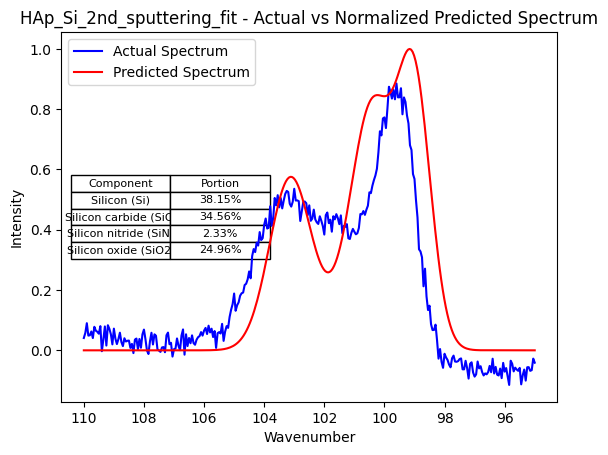

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os

# Load the saved model
model = load_model('CNN_Model_Component_Binding_Energies_v2.h5')

# Function to generate multiple spectra as a sum of Gaussians
def generate_multiple_spectra(amplitudes, centers, fwhms):
    x_range = np.arange(95, 110, 0.05)
    all_spectra = []

    for i in range(len(centers)):
        spectrum = np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhms[i] / (2.35482))**2)) for j in range(len(centers))], axis=0)
        all_spectra.append(spectrum)

    final_spectrum = np.sum(all_spectra, axis=0)
    return final_spectrum

# Define components with binding energies and FWHMs
components = {
    'Silicon (Si)': (99, 1.30),
    'Silicon carbide (SiC)': (100.4, 1.65),
    'Silicon nitride (SiN)': (101.6, 1.65),
    'Silicon oxide (SiO2)': (103.1, 1.65)
}

# Load new data from CSV
file_path = 'ExperimentalData/HAp_Si_2nd_sputtering_fit.csv'
data = pd.read_csv(file_path, names=["Wavenumber", "Intensity"])
file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extracts the file name without extension

# Assuming spectrum_min and spectrum_max are defined earlier
spectrum_min, spectrum_max = 95.0, 110.0

data['Wavenumber'] = pd.to_numeric(data['Wavenumber'], errors='coerce')
data['Intensity'] = pd.to_numeric(data['Intensity'], errors='coerce')

# Filter data within the specified wavenumber range
filtered_data = data[(data['Wavenumber'] >= spectrum_min) & (data['Wavenumber'] <= spectrum_max)].copy()
filtered_data = filtered_data.dropna(subset=['Intensity'])

# Preprocess the filtered data
min_value = np.min(filtered_data['Intensity'] )
max_value = np.max(filtered_data['Intensity'] )
spectraData_normalized = (filtered_data['Intensity'] - min_value) / (max_value - min_value)
filtered_data['Intensity'] =spectraData_normalized

# Calculating background value and subtracting it using spectrum_min and spectrum_max
background_data1 = filtered_data[(filtered_data['Wavenumber'] >= spectrum_min) & (filtered_data['Wavenumber'] <= 95)]
background_data2 = filtered_data[(filtered_data['Wavenumber'] >= 110) & (filtered_data['Wavenumber'] <= spectrum_max)]

background_value1 = background_data1['Intensity'].mean()
background_value2 = background_data2['Intensity'].mean()

# Using the average of these two values as the overall background value
background_value = np.mean([background_value1, background_value2])
filtered_data['Intensity'] -= background_value

# Prepare data for interpolation
x = filtered_data['Wavenumber']
y = filtered_data['Intensity']
x_normalized = (x - spectrum_min) / (spectrum_max - spectrum_min)

num_specific_frequencies=4
interpolated_Intensity = np.zeros((num_specific_frequencies, 250))  # Initialize interpolated array
f = interp1d(x_normalized, y, kind='linear', fill_value="extrapolate")
start = 95
end = 110
step = 0.05
num_points = int((end - start) / step)
new_x = np.linspace(0, 1, num_points)

interpolated_Intensity = f(new_x)
interpolated_Intensity = interpolated_Intensity.reshape(1, -1, num_specific_frequencies)

predicted_amplitudes = model.predict(interpolated_Intensity )

predicted_amplitudes_flat = predicted_amplitudes.flatten()

# Calculate the spectrum of predicted amplitudes
predicted_spectrum = generate_multiple_spectra(predicted_amplitudes_flat, [comp[0] for comp in components.values()], [comp[1] for comp in components.values()])

# Normalize the predicted spectrum
predicted_spectrum_normalized = (predicted_spectrum - np.min(predicted_spectrum)) / (np.max(predicted_spectrum) - np.min(predicted_spectrum))

# Calculate the total intensity of the predicted spectrum after normalization
total_intensity_normalized = np.sum(predicted_spectrum_normalized)

# Plot both the actual and normalized predicted spectra
plt.plot(filtered_data['Wavenumber'], filtered_data['Intensity'], label='Actual Spectrum', color='blue')
plt.plot(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized, label='Predicted Spectrum', color='red')

# Add a table with labels for the portions of each component based on predicted amplitudes
total_intensity = np.sum(predicted_amplitudes_flat)
table_data = [['Component', 'Portion']]
for component_name, (component_energy, _) in components.items():
    component_amplitude = predicted_amplitudes_flat[list(components.keys()).index(component_name)]
    portion = component_amplitude / total_intensity
    table_data.append([component_name, f'{portion * 100:.2f}%'])

# Create a table with custom font properties
table = plt.table(cellText=table_data, loc='center left', colWidths=[0.2, 0.2], cellLoc='center', colLabels=None)
table.auto_set_font_size(False)
table.set_fontsize(8)

# Add file name to the plot title
plt.title(f'{file_name} - Actual vs Normalized Predicted Spectrum')

plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.gca().invert_xaxis()
plt.show()


In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/XPS')

Mounted at /content/drive
